# Using Reddit's API for Predicting Comments

In this project, we will practice two major skills. Collecting data via an API request and then building a binary predictor.

As we discussed in week 2, and earlier today, there are two components to starting a data science problem: the problem statement, and acquiring the data.

For this article, your problem statement will be: _What characteristics of a post on Reddit contribute most to the overall interaction (as measured by number of comments)?_

Your method for acquiring the data will be scraping the 'hot' threads as listed on the [Reddit homepage](https://www.reddit.com/). You'll acquire _AT LEAST FOUR_ pieces of information about each thread:
1. The title of the thread
2. The subreddit that the thread corresponds to
3. The length of time it has been up on Reddit
4. The number of comments on the thread

Once you've got the data, you will build a classification model that, using Natural Language Processing and any other relevant features, predicts whether or not a given Reddit post will have above or below the _median_ number of comments.

**BONUS PROBLEMS**
1. If creating a logistic regression, GridSearch Ridge and Lasso for this model and report the best hyperparameter values.
1. Scrape the actual text of the threads using Selenium (you'll learn about this in Webscraping II).
2. Write the actual article that you're pitching and turn it into a blog post that you host on your personal website.

### Scraping Thread Info from Reddit.com

#### Set up a request (using requests) to the URL below. 

*NOTE*: Reddit will throw a [429 error](https://httpstatuses.com/429) when using the following code:
```python
res = requests.get(URL)
```

This is because Reddit has throttled python's default user agent. You'll need to set a custom `User-agent` to get your request to work.
```python
res = requests.get(URL, headers={'User-agent': 'YOUR NAME Bot 0.1'})
```

In [1]:
import requests
import json

URL = "http://www.reddit.com/hot.json"

In [2]:
## YOUR CODE HERE

res = requests.get(URL, headers = {'User-agent': 'gadamico Bot 0.1'})

res.status_code

200

#### Use `res.json()` to convert the response into a dictionary format and set this to a variable. 

```python
data = res.json()
```

In [3]:
reddits = res.json()

#### Getting more results

By default, Reddit will give you the top 25 posts:

```python
print(len(data['data']['children']))
```

If you want more, you'll need to do two things:
1. Get the name of the last post: `data['data']['after']`
2. Use that name to hit the following url: `http://www.reddit.com/hot.json?after=THE_AFTER_FROM_STEP_1`
3. Create a loop to repeat steps 1 and 2 until you have a sufficient number of posts. 

*NOTE*: Reddit will limit the number of requests per second you're allowed to make. When you create your loop, be sure to add the following after each iteration.

```python
time.sleep(3) # sleeps 3 seconds before continuing```

This will throttle your loop and keep you within Reddit's guidelines. You'll need to import the `time` library for this to work!

In [4]:
## Exploration.

reddits['data']['children'][0]['data']

{'approved_at_utc': None,
 'approved_by': None,
 'archived': False,
 'author': 'xTRMED1',
 'author_flair_css_class': None,
 'author_flair_template_id': None,
 'author_flair_text': None,
 'banned_at_utc': None,
 'banned_by': None,
 'can_gild': False,
 'can_mod_post': False,
 'clicked': False,
 'contest_mode': False,
 'created': 1527554713.0,
 'created_utc': 1527525913.0,
 'distinguished': None,
 'domain': 'i.imgur.com',
 'downs': 0,
 'edited': False,
 'gilded': 0,
 'hidden': False,
 'hide_score': False,
 'id': '8mrge0',
 'is_crosspostable': False,
 'is_reddit_media_domain': False,
 'is_self': False,
 'is_video': False,
 'likes': None,
 'link_flair_css_class': None,
 'link_flair_text': None,
 'locked': False,
 'media': None,
 'media_embed': {},
 'media_only': False,
 'mod_note': None,
 'mod_reason_by': None,
 'mod_reason_title': None,
 'mod_reports': [],
 'name': 't3_8mrge0',
 'no_follow': False,
 'num_comments': 224,
 'num_crossposts': 1,
 'num_reports': None,
 'over_18': False,
 'paren

In [5]:
attr_types = [type(reddits['data']['children'][0]['data'][attr]) == bool for attr in reddits['data']['children'][0]['data']]

reddits['data']['children'][0]['data'].keys()

vars = dict(zip(reddits['data']['children'][0]['data'].keys(), attr_types))

vars

{'approved_at_utc': False,
 'approved_by': False,
 'archived': True,
 'author': False,
 'author_flair_css_class': False,
 'author_flair_template_id': False,
 'author_flair_text': False,
 'banned_at_utc': False,
 'banned_by': False,
 'can_gild': True,
 'can_mod_post': True,
 'clicked': True,
 'contest_mode': True,
 'created': False,
 'created_utc': False,
 'distinguished': False,
 'domain': False,
 'downs': False,
 'edited': True,
 'gilded': False,
 'hidden': True,
 'hide_score': True,
 'id': False,
 'is_crosspostable': True,
 'is_reddit_media_domain': True,
 'is_self': True,
 'is_video': True,
 'likes': False,
 'link_flair_css_class': False,
 'link_flair_text': False,
 'locked': True,
 'media': False,
 'media_embed': False,
 'media_only': True,
 'mod_note': False,
 'mod_reason_by': False,
 'mod_reason_title': False,
 'mod_reports': False,
 'name': False,
 'no_follow': True,
 'num_comments': False,
 'num_crossposts': False,
 'num_reports': False,
 'over_18': True,
 'parent_whitelist_sta

In [6]:
reddits['data']['children'][0]['data']['title']

'Dave Bautista has achieved full Drax.'

In [7]:
print(len(reddits['data']['children']))

25


In [1]:
import pandas as pd
import time

In [8]:
reddits['data']['after']

't3_8mpuz1'

### Save your results as a CSV
You may do this regularly while scraping data as well, so that if your scraper stops or your computer crashes, you don't lose all your data.

In [9]:
# The scraper

more_reddits = []
for _ in range(9):
    URL = 'http://www.reddit.com/hot.json?after=' + res.json()['data']['after']
    res = requests.get(URL, headers = {'User-agent': 'gadamico Bot 0.1'})
    for num in range(len(res.json()['data']['children'])):
        more_reddits.append(res.json()['data']['children'][num]['data'])
    
    time.sleep(3)
redditsdf = pd.DataFrame(more_reddits)
redditscsv9 = redditsdf.to_csv('reddits9.csv')

In [14]:
# Exploring the structure of the reddit posts

more_reddits[0].keys()

dict_keys(['is_crosspostable', 'subreddit_id', 'approved_at_utc', 'wls', 'mod_reason_by', 'banned_by', 'num_reports', 'removal_reason', 'thumbnail_width', 'subreddit', 'selftext_html', 'author_flair_template_id', 'selftext', 'likes', 'suggested_sort', 'user_reports', 'secure_media', 'is_reddit_media_domain', 'saved', 'id', 'banned_at_utc', 'mod_reason_title', 'view_count', 'archived', 'clicked', 'no_follow', 'author', 'num_crossposts', 'link_flair_text', 'can_mod_post', 'send_replies', 'pinned', 'score', 'approved_by', 'over_18', 'report_reasons', 'domain', 'hidden', 'preview', 'pwls', 'thumbnail', 'edited', 'link_flair_css_class', 'media_only', 'author_flair_css_class', 'contest_mode', 'gilded', 'locked', 'downs', 'mod_reports', 'subreddit_subscribers', 'secure_media_embed', 'media_embed', 'post_hint', 'stickied', 'visited', 'can_gild', 'thumbnail_height', 'name', 'spoiler', 'permalink', 'subreddit_type', 'parent_whitelist_status', 'hide_score', 'created', 'url', 'author_flair_text', 

In [15]:
reddits_df = pd.DataFrame(more_reddits)

reddits_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 83 columns):
approved_at_utc             0 non-null object
approved_by                 0 non-null object
archived                    225 non-null bool
author                      225 non-null object
author_flair_css_class      0 non-null object
author_flair_template_id    0 non-null object
author_flair_text           0 non-null object
banned_at_utc               0 non-null object
banned_by                   0 non-null object
can_gild                    225 non-null bool
can_mod_post                225 non-null bool
clicked                     225 non-null bool
contest_mode                225 non-null bool
created                     225 non-null float64
created_utc                 225 non-null float64
crosspost_parent            8 non-null object
crosspost_parent_list       8 non-null object
distinguished               1 non-null object
domain                      225 non-null object
downs      

In [1]:
from sklearn import naive_bayes 
import pandas as pd

In [7]:
titles = []
for i in range(25):
    titles.append(reddits['data']['children'][i]['data']['title'])

In [25]:
titlesdf = pd.DataFrame(titles, columns = ['title'])

In [26]:
y = []
for i in range(25):
    y.append(reddits['data']['children'][i]['data']['num_comments'])
ydf = pd.DataFrame(y, columns = ['comments'])

In [27]:
df_comments = pd.concat([titlesdf, ydf], axis = 1)

In [29]:
df_comments['comments'].median()

325.0

## Experimenting with the NLP Vectorizer

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words = 'english')

In [11]:
tfidf.fit(titles)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [12]:
df = pd.DataFrame(tfidf.transform(titles).todense(), columns = tfidf.get_feature_names())

In [30]:
df.head()

,000,3780x5102,98,accuse,actors,adopt,anon,app,arrives,behavior,...,using,walking,warp,wcgw,weeks,wifi,women,years,youngest,zero
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.383893,0.0,0.0,0.0,0.0,0.0,0.383893,...,0.0,0.0,0.0,0.0,0.0,0.0,0.34023,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0


In [33]:
df_all = pd.concat([df_comments, df], axis = 1)

In [38]:
df_all

,title,comments,000,3780x5102,98,accuse,actors,adopt,anon,app,...,using,walking,warp,wcgw,weeks,wifi,women,years,youngest,zero
0,Trump says Singapore summit with North Korea l...,7772,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,The game within the game,216,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Women accuse Morgan Freeman of inappropriate b...,4413,0.000000,0.0,0.000000,0.383893,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.340230,0.000000,0.000000,0.000000
3,A great skateboard trick,504,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,A day in a rhino's life,1144,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Slamming this bottle on the ground wcgw.,235,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,The endangered Irrawaddy dolphin,281,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Oregon Coast. [3780x5102] [OC],692,0.000000,0.5,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,"My great grandmother and her youngest son, who...",161,0.000000,0.0,0.202038,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.202038,0.000000,0.0,0.202038,0.000000,0.000000,0.179059,0.202038,0.000000
9,The US military released a study on time trave...,2150,0.253421,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.253421,0.0,0.000000,0.000000,0.000000,0.224598,0.000000,0.253421


In [43]:
df_all['success'] = df_all['comments'] >= df_all['comments'].median()

In [44]:
df_all

,title,comments,000,3780x5102,98,accuse,actors,adopt,anon,app,...,walking,warp,wcgw,weeks,wifi,women,years,youngest,zero,success
0,Trump says Singapore summit with North Korea l...,7772,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,True
1,The game within the game,216,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False
2,Women accuse Morgan Freeman of inappropriate b...,4413,0.000000,0.0,0.000000,0.383893,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.340230,0.000000,0.000000,0.000000,True
3,A great skateboard trick,504,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,True
4,A day in a rhino's life,1144,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,True
5,Slamming this bottle on the ground wcgw.,235,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False
6,The endangered Irrawaddy dolphin,281,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False
7,Oregon Coast. [3780x5102] [OC],692,0.000000,0.5,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,True
8,"My great grandmother and her youngest son, who...",161,0.000000,0.0,0.202038,0.000000,0.000000,0.000000,0.0,0.000000,...,0.202038,0.000000,0.0,0.202038,0.000000,0.000000,0.179059,0.202038,0.000000,False
9,The US military released a study on time trave...,2150,0.253421,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.253421,0.0,0.000000,0.000000,0.000000,0.224598,0.000000,0.253421,True


## Initial Assembly. Adding an 'Accessed' Column.

In [ ]:
red1 = pd.read_csv('reddits1.csv', index_col = 'name')

red1['Accessed'] = '24 May 2018 05:40'

red1['Accessed'] = pd.to_datetime(red1['Accessed'], utc = True)

In [ ]:
red2 = pd.read_csv('reddits2.csv', index_col = 'name')

red2['Accessed'] = '24 May 2018 06:08'

red2['Accessed'] = pd.to_datetime(red2['Accessed'], utc = True)

In [10]:
red3 = pd.read_csv('reddits3.csv', index_col = 'name')

red3['Accessed'] = '24 May 2018 15:52'

red3['Accessed'] = pd.to_datetime(red3['Accessed'], utc = True)

In [58]:
reds = pd.concat([red1, red2, red3])

In [59]:
reds.shape

(7425, 84)

In [60]:
reds.drop_duplicates(subset = 'title', inplace = True)

In [61]:
reds.shape

(3978, 84)

## (Optional) Collect more information

While we only require you to collect four features, there may be other info that you can find on the results page that might be useful. Feel free to write more functions so that you have more interesting and useful data.

### Defining 'Success' and Exploring Correlations Therewith

In [62]:
reds['success'] = reds['num_comments'] >= reds['num_comments'].median()

In [94]:
reds.corr()['success']

Unnamed: 0                 -0.323966
approved_at_utc                  NaN
approved_by                      NaN
archived                         NaN
author_flair_css_class           NaN
author_flair_template_id         NaN
author_flair_text                NaN
banned_at_utc                    NaN
banned_by                        NaN
can_gild                         NaN
can_mod_post                     NaN
clicked                          NaN
contest_mode               -0.015881
created                    -0.305585
created_utc                -0.305585
downs                            NaN
gilded                      0.077925
hidden                           NaN
hide_score                 -0.093275
is_crosspostable                 NaN
is_reddit_media_domain     -0.142841
is_self                     0.175250
is_video                    0.048373
likes                            NaN
locked                      0.033430
media_only                       NaN
mod_note                         NaN
m

In [99]:
o18dums = pd.get_dummies(reds['over_18'], drop_first = True)

reds_o18dums = pd.concat([reds, o18dums], axis = 1)

reds_o18dums.corr()['success']

Unnamed: 0                 -0.323966
approved_at_utc                  NaN
approved_by                      NaN
archived                         NaN
author_flair_css_class           NaN
author_flair_template_id         NaN
author_flair_text                NaN
banned_at_utc                    NaN
banned_by                        NaN
can_gild                         NaN
can_mod_post                     NaN
clicked                          NaN
contest_mode               -0.015881
created                    -0.305585
created_utc                -0.305585
downs                            NaN
gilded                      0.077925
hidden                           NaN
hide_score                 -0.093275
is_crosspostable                 NaN
is_reddit_media_domain     -0.142841
is_self                     0.175250
is_video                    0.048373
likes                            NaN
locked                      0.033430
media_only                       NaN
mod_note                         NaN
m

The ```over_18``` tag has very little correlation with success.

In [158]:
reds['is_crosspostable'].value_counts()

False    3978
Name: is_crosspostable, dtype: int64

In [159]:
reds['can_mod_post'].value_counts()

False    3978
Name: can_mod_post, dtype: int64

In [162]:
selfdums = pd.get_dummies(reds['is_self'], drop_first = True)

In [163]:
reds_selfdums = pd.concat([reds, selfdums], axis = 1)

In [164]:
reds_selfdums.corr()['success']

Unnamed: 0                 -0.323966
approved_at_utc                  NaN
approved_by                      NaN
archived                         NaN
author_flair_css_class           NaN
author_flair_template_id         NaN
author_flair_text                NaN
banned_at_utc                    NaN
banned_by                        NaN
can_gild                         NaN
can_mod_post                     NaN
clicked                          NaN
contest_mode               -0.015881
created                    -0.305585
created_utc                -0.305585
downs                            NaN
gilded                      0.077925
hidden                           NaN
hide_score                 -0.093275
is_crosspostable                 NaN
is_reddit_media_domain     -0.142841
is_self                     0.175250
is_video                    0.048373
likes                            NaN
locked                      0.033430
media_only                       NaN
mod_note                         NaN
m

Not much here, either.

In [12]:
reds.columns

Index(['Unnamed: 0', 'approved_at_utc', 'approved_by', 'archived', 'author',
       'author_cakeday', 'author_flair_css_class', 'author_flair_template_id',
       'author_flair_text', 'banned_at_utc', 'banned_by', 'can_gild',
       'can_mod_post', 'clicked', 'contest_mode', 'created', 'created_utc',
       'crosspost_parent', 'crosspost_parent_list', 'distinguished', 'domain',
       'downs', 'edited', 'gilded', 'hidden', 'hide_score', 'id',
       'is_crosspostable', 'is_reddit_media_domain', 'is_self', 'is_video',
       'likes', 'link_flair_css_class', 'link_flair_text', 'locked', 'media',
       'media_embed', 'media_only', 'mod_note', 'mod_reason_by',
       'mod_reason_title', 'mod_reports', 'no_follow', 'num_comments',
       'num_crossposts', 'num_reports', 'over_18', 'parent_whitelist_status',
       'permalink', 'pinned', 'post_categories', 'post_hint', 'preview',
       'previous_visits', 'pwls', 'quarantine', 'removal_reason',
       'report_reasons', 'saved', 'score', 'se

In [83]:
reds['author_flair_text'].value_counts()

Series([], Name: author_flair_text, dtype: int64)

In [84]:
reds['parent_whitelist_status'].value_counts()

all_ads             2850
promo_specified      207
no_ads                63
house_only            38
promo_adult           36
promo_adult_nsfw      22
promo_all             18
Name: parent_whitelist_status, dtype: int64

In [63]:
pwlsdums = pd.get_dummies(reds['parent_whitelist_status'])

In [64]:
reds_pwlsdums = pd.concat([reds, pwlsdums], axis = 1)

In [65]:
reds_pwlsdums.corr()['success']

Unnamed: 0                 -0.323966
approved_at_utc                  NaN
approved_by                      NaN
archived                         NaN
author_flair_css_class           NaN
author_flair_template_id         NaN
author_flair_text                NaN
banned_at_utc                    NaN
banned_by                        NaN
can_gild                         NaN
can_mod_post                     NaN
clicked                          NaN
contest_mode               -0.015881
created                    -0.305585
created_utc                -0.305585
downs                            NaN
gilded                      0.077925
hidden                           NaN
hide_score                 -0.093275
is_crosspostable                 NaN
is_reddit_media_domain     -0.142841
is_self                     0.175250
is_video                    0.048373
likes                            NaN
locked                      0.033430
media_only                       NaN
mod_note                         NaN
m

In [ ]:
# engineer: 'parent_whitelist_status_all_ads',
# 'score', 'num_comments', 'num_crossposts', 'subreddit_subscribers'

In [89]:
pd.isnull(reds['subreddit_subscribers']).sum()

0

In [90]:
pd.isnull(reds['num_crossposts']).sum()

0

In [91]:
pd.isnull(reds['num_comments']).sum()

0

In [92]:
pd.isnull(reds['score']).sum()

0

## Putting the Whole Dataset Together

In [2]:
red1 = pd.read_csv('reddits1.csv', index_col = 'name')

red1['Accessed'] = '24 May 2018 05:40'

red1['Accessed'] = pd.to_datetime(red1['Accessed'], utc = True)

In [3]:
red2 = pd.read_csv('reddits2.csv', index_col = 'name')

red2['Accessed'] = '24 May 2018 06:08'

red2['Accessed'] = pd.to_datetime(red2['Accessed'], utc = True)

In [4]:
red3 = pd.read_csv('reddits3.csv', index_col = 'name')

red3['Accessed'] = '24 May 2018 15:52'

red3['Accessed'] = pd.to_datetime(red3['Accessed'], utc = True)

In [5]:
red4 = pd.read_csv('reddits4.csv', index_col = 'name')

red4['Accessed'] = '24 May 2018 16:15'

red4['Accessed'] = pd.to_datetime(red4['Accessed'], utc = True)

In [6]:
red5 = pd.read_csv('reddits5.csv', index_col = 'name')

red5['Accessed'] = '24 May 2018 18:09'

red5['Accessed'] = pd.to_datetime(red5['Accessed'], utc = True)

In [7]:
red6 = pd.read_csv('reddits6.csv', index_col = 'name')

red6['Accessed'] = '24 May 2018 20:48'

red6['Accessed'] = pd.to_datetime(red6['Accessed'], utc = True)

In [8]:
allreds = pd.concat([red1, red2, red3, red4, red5, red6])

In [9]:
allreds.drop_duplicates(subset = 'title', inplace = True)

In [10]:
allreds.shape

(7775, 86)

In [18]:
allreds['pwlsAllAds'] = allreds['parent_whitelist_status'] == 'all_ads'

In [15]:
allreds['pwlsAllAds'].value_counts()

True     5628
False    2147
Name: pwlsAllAds, dtype: int64

In [12]:
allreds['success?'] = allreds['num_comments'] >= allreds['num_comments'].median()

In [20]:
allreds['num_comments'].median()

14.0

In [14]:
allreds['num_comments'].max()

29719

In [52]:
ncdf = pd.DataFrame(allreds['num_comments']).sort_values(by = 'num_comments', ascending = False)

In [53]:
ncdf.head()

,num_comments
name,
t3_8lj4fn,29719
t3_8llrif,6747
t3_8lkp31,6451
t3_8lr3nw,5315
t3_8lrmbg,4420


In [90]:
sum(ncdf['num_comments'] < 2)

570

In [72]:
import matplotlib

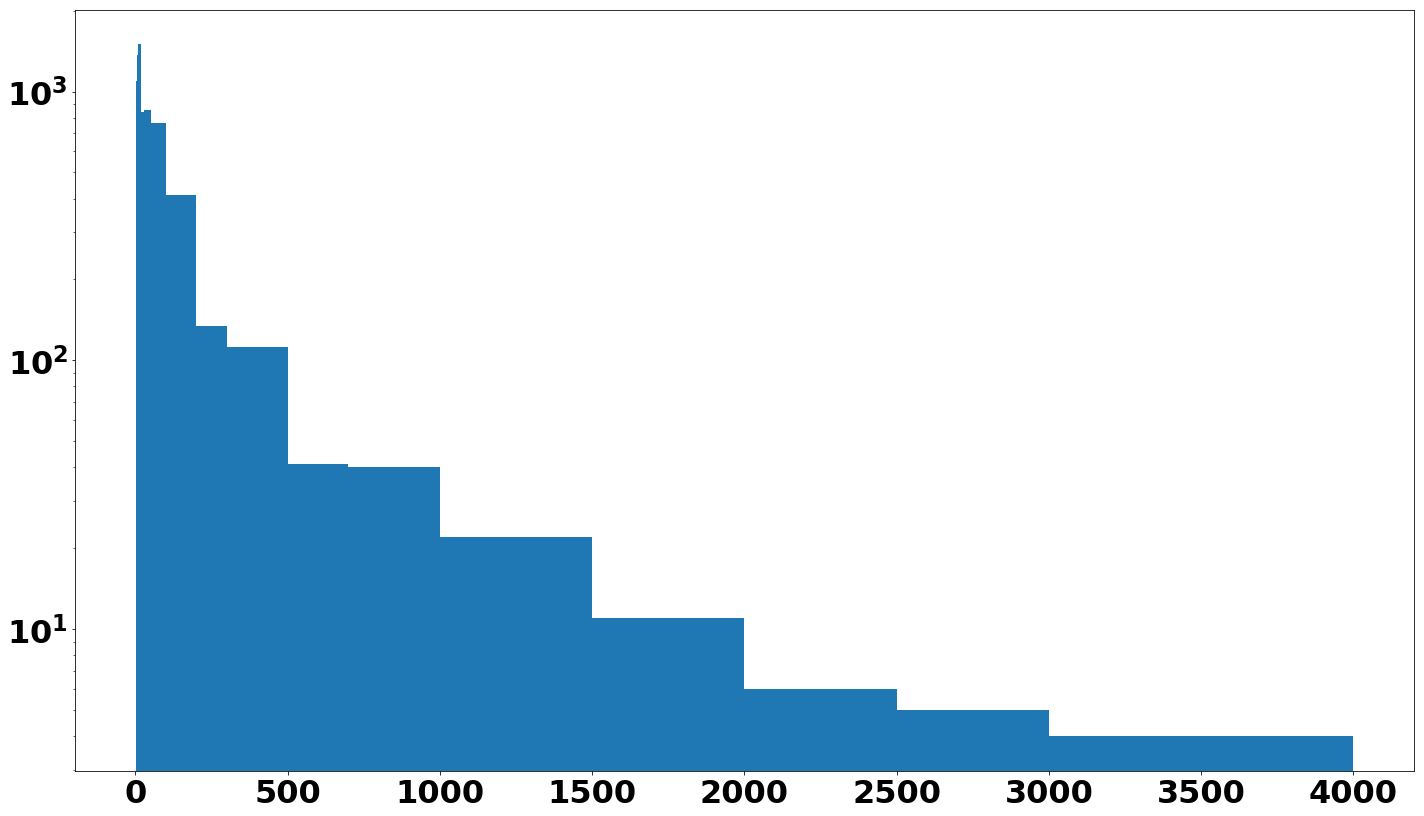

In [86]:
matplotlib.pyplot.hist(ncdf['num_comments'], bins = [2, 5, 10, 20, 30, 50,
                                       100, 200, 300, 500, 700,
                                                     1000, 1500,
                                                     2000, 2500,
                                                     3000, 4000
                                                     ], log = True)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(24, 14)

font = {'weight' : 'bold',
        'size'   : 32}

matplotlib.rc('font', **font)

In [33]:
# allreds['Date'] = pd.to_datetime(allreds['created_utc'], utc = True, unit = 's')

# allreds['Date'].min()

Timestamp('2018-05-23 05:40:50+0000', tz='UTC')

In [21]:
allreds['Age'] = allreds['Accessed'] - pd.to_datetime(allreds['created_utc'],
                                                      utc = True, unit = 's')

In [22]:
allreds['Age'].min()

Timedelta('0 days 00:17:27')

In [23]:
allreds['Age'].max()

Timedelta('0 days 23:59:10')

In [24]:
subdums = pd.get_dummies(allreds['subreddit'])

In [117]:
allreds_subdums = pd.concat([allreds, subdums], axis = 1)

In [25]:
X = pd.concat([allreds[['pwlsAllAds', 'score', 'num_crossposts', 'subreddit_subscribers', 'Age',
             'title']], subdums], axis = 1)

In [26]:
y = allreds['success?']

In [21]:
subdums_y = pd.concat([subdums, y], axis = 1)

In [22]:
subdums_y.corr()['success'].sort_values(ascending = True).head(20)

goddesses             -0.052437
Memes_Of_The_Dank     -0.045893
sexygirls             -0.038866
unket                 -0.037055
Rabbits               -0.035958
HistoryMemes          -0.035958
Megumin               -0.035151
blackcats             -0.034040
ik_ihe                -0.032019
kpics                 -0.030996
PanPorn               -0.030996
ImaginaryCharacters   -0.030996
wholesomememes        -0.030255
HoldMyKibble          -0.028695
ProEDmemes            -0.028695
LoveNikki             -0.028695
NatureIsFuckingLit    -0.028319
Floof                 -0.027582
AskHistorians         -0.027582
castles               -0.027484
Name: success, dtype: float64

Top 20 subreddits as of 1:00 PM on Friday, May 25: FortNiteBR, AskReddit, funny, AskOuija, gaming, formula1, news, pics, FireEmblemHeroes, LivestreamFail, marvelstudios, MemeEconomy, NintendoSwitch, movies, rupaulsdragrace, de, CringeAnarchy, aww, MMA.

Bottom 20 subreddits as of 1:00 PM on Friday, May 25: goddesses, Memes_Of_The_Dank, sexygirls, unket, Rabbits, HistoryMemes, Megumin, blackcats, ik_ihe, kpics, PanPorn, ImaginaryCharacters, wholesomememes, HoldMyKibble, ProEDmemes, LoveNikki, NatureIsFuckingLit, Floof, AskHistorians, castles.

In [23]:
subcols = ['FortNiteBR', 'AskReddit', 'funny', 'AskOuija', 'gaming',
     'Rabbits', 'unket', 'sexygirls', 'Memes_Of_The_Dank', 'goddesses']

In [24]:
subdums_plotting = pd.concat([subdums_y[subcols], subdums_y['success']], axis = 1)

In [25]:
subdums_plotting.corr()['success']

FortNiteBR           0.058240
AskReddit            0.058224
funny                0.057191
AskOuija             0.051590
gaming               0.050814
Rabbits             -0.035958
unket               -0.037055
sexygirls           -0.038866
Memes_Of_The_Dank   -0.045893
goddesses           -0.052437
success              1.000000
Name: success, dtype: float64

In [40]:
import matplotlib
import seaborn as sns

%matplotlib inline

In [27]:
corrs = pd.DataFrame(subdums_plotting.corr()['success'], index = subcols)

In [28]:
corrs.reset_index(level = 0, inplace = True)

In [29]:
corrs

,index,success
0,FortNiteBR,0.058240
1,AskReddit,0.058224
2,funny,0.057191
3,AskOuija,0.051590
4,gaming,0.050814
5,Rabbits,-0.035958
6,unket,-0.037055
7,sexygirls,-0.038866
8,Memes_Of_The_Dank,-0.045893
9,goddesses,-0.052437


In [30]:
corrs['index'] = ['A - FortNiteBR', 'B - AskReddit', 'C - funny', 'D - AskOuija', 'E - gaming',
                 'F - Rabbits', 'G - unket', 'H - sexygirls', 'I - Memes_Of_The_Dank',
                 'J - goddesses']

/Users/gadamico/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


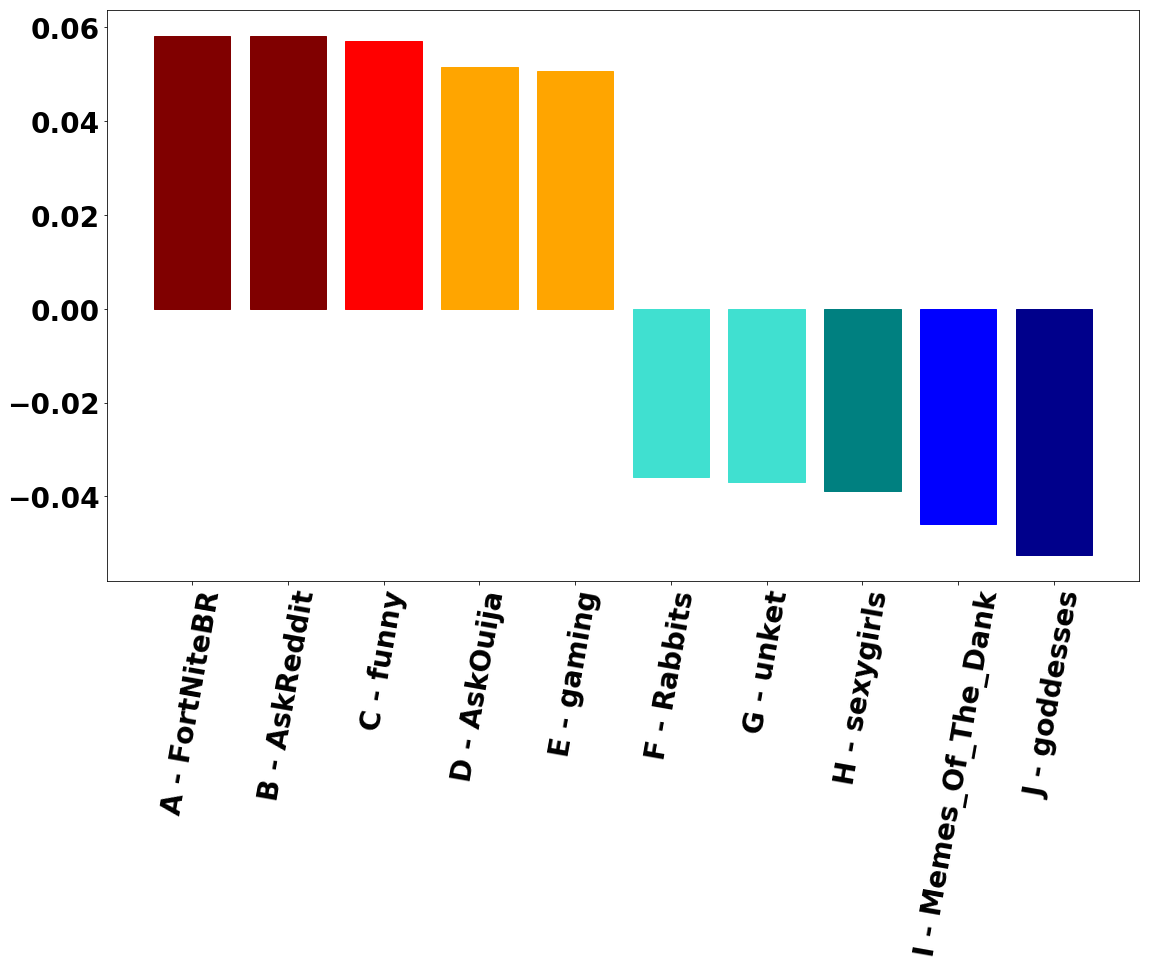

In [48]:
bars = matplotlib.pyplot.bar(corrs['index'], corrs['success'])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
bars[0].set_color('maroon')
bars[1].set_color('maroon')
bars[2].set_color('r')
bars[3].set_color('orange')
bars[4].set_color('orange')
bars[5].set_color('turquoise')
bars[6].set_color('turquoise')
bars[7].set_color('teal')
bars[8].set_color('b')
bars[9].set_color('darkblue')

font = {'weight' : 'bold',
        'size'   : 28}

matplotlib.rc('font', **font)
matplotlib.pyplot.xticks(rotation = 80);

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words = 'english')

In [31]:
title_list = X['title'].tolist()

In [32]:
from sklearn.model_selection import cross_val_score

In [33]:
X.head()

,pwlsAllAds,score,num_crossposts,subreddit_subscribers,Age,title,0xProject,100yearsago,1200isjerky,13ReasonsWhy,...,yesyesyesno,yesyesyesyesno,ynab,youdontsurf,youseeingthisshit,youtube,youtubehaiku,yvonnestrahovski,zelda,zuckmemes
new_index,,,,,,,,,,,,,,,,,,,,,
0,True,7921,0,450017,08:38:13,decent excuse,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,True,4681,5,680944,07:12:17,And turn.,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,False,3621,0,63554,06:09:56,"I miss her everyday, she was such a good kitty.",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,True,3615,2,15288041,06:06:56,"Northern Lights, Andromeda and NGC 752 (presum...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,True,5010,0,18705399,07:59:40,"NASA head Jim Bridenstine, once doubtful, conf...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now time to collect titles into a list (before vectorizing).

In [34]:
tfidf_all = tfidf.fit(title_list)

In [35]:
df_titles_all = pd.DataFrame(tfidf.transform(title_list).todense(),
                             columns = tfidf.get_feature_names())

In [36]:
df_titles_all.shape

(7775, 14501)

In [100]:
means = [df_titles_all[column].mean() for column in df_titles_all.columns]

df_titles_T = df_titles_all.T

df_titles_T['means'] = means

df_titles_T.sort_values('means', ascending=False).head(30).transpose()

,just,new,like,time,got,day,don,today,game,think,...,little,know,old,guys,years,finally,cat,real,life,2018
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.378749,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.193937,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.378186,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Most common words (irrelevant of success): 'just', 'new', 'like', 'time', 'got', 'day', 'don't', 'today', 'game', 'think'.

In [27]:
X['new_index'] = range(X.shape[0])

In [28]:
X = X.set_index('new_index')

In [37]:
X.shape

(7775, 2567)

In [38]:
df_titles_all.shape

(7775, 14501)

In [39]:
y.shape

(7775,)

In [40]:
ydf = pd.DataFrame(y)

In [41]:
ydf['new_index'] = range(y.shape[0])

In [42]:
ydf = ydf.set_index('new_index')

In [43]:
ydf.shape

(7775, 1)

In [44]:
df_all_all = pd.concat([X, df_titles_all, ydf], axis = 1)

In [45]:
df_all_all.shape

(7775, 17069)

In [138]:
df_all_success = df_all_all.loc[df_all_all['success?'] == True, :]

In [140]:
df_all_failure = df_all_all.loc[df_all_all['success?'] == False, :]

In [162]:
cols = list(range(2567))
cols.append(17068)
df_all_succ_titles = df_all_success.drop(df_all_success.columns[cols],axis=1)

means_succ = [df_all_succ_titles[column].mean() for column in df_all_succ_titles.columns]

df_succ_titles_T = df_all_succ_titles.T

df_succ_titles_T['means'] = means_succ

df_succ_titles_T.sort_values('means', ascending=False).head(30).transpose()

,just,new,like,time,game,don,today,people,make,got,...,going,best,right,know,trump,does,work,life,need,guys
new_index,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.378749,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.378186,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Words of success: 'just', 'new', 'like', 'time', 'game', 'don't', 'today', 'people', 'make', 'got'.

In [167]:
df_succ_titles_T.sort_values('means', ascending=False).head(30).transpose().columns

Index(['just', 'new', 'like', 'time', 'game', 'don', 'today', 'people', 'make',
       'got', 'think', 'love', 'man', 'day', 've', 'did', 'good', 'years',
       '2018', 'oc', 'going', 'best', 'right', 'know', 'trump', 'does', 'work',
       'life', 'need', 'guys'],
      dtype='object')

In [163]:
df_all_fail_titles = df_all_failure.drop(df_all_failure.columns[cols],axis=1)

means_fail = [df_all_fail_titles[column].mean() for column in df_all_fail_titles.columns]

df_fail_titles_T = df_all_fail_titles.T

df_fail_titles_T['means'] = means_fail

df_fail_titles_T.sort_values('means', ascending=False).head(30).transpose()

,just,like,new,time,got,day,oc,best,good,post,...,man,today,irl,guys,people,looking,cat,did,dog,way
new_index,,,,,,,,,,,,,,,,,,,,,
105,0.000000,0.000000,0.306960,0.000000,0.344096,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
155,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
175,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
190,0.000000,0.000000,0.000000,0.344209,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
255,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
261,0.000000,0.000000,0.000000,0.000000,0.000000,0.200121,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
314,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
315,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
321,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Words of failure: 'just', 'like', 'new', 'time', 'got', 'day', 'oc', 'best', 'good', 'post'.

In [169]:
df_fail_titles_T.sort_values('means', ascending=False).head(30).transpose().columns

Index(['just', 'like', 'new', 'time', 'got', 'day', 'oc', 'best', 'good',
       'post', 'little', 'don', 'think', 'real', 'old', 'know', 've',
       'finally', 'love', 'girl', 'man', 'today', 'irl', 'guys', 'people',
       'looking', 'cat', 'did', 'dog', 'way'],
      dtype='object')

In [171]:
intersect = df_fail_titles_T.sort_values('means', ascending = False).head(30).transpose().columns.intersection(df_succ_titles_T.sort_values('means', ascending = False).head(30).transpose().columns)

In [172]:
intersect

Index(['just', 'like', 'new', 'time', 'got', 'day', 'oc', 'best', 'good',
       'don', 'think', 'know', 've', 'love', 'man', 'today', 'guys', 'people',
       'did'],
      dtype='object')

In Top 30 success words, not in Top 30 failure words: 'game', 'make', 'years', '2018', 'going', 'right', 'trump', 'does', 'work', 'life', 'need'.

In Top 30 failure words, not in Tope 30 success words: 'post', 'little', 'real', 'old', 'finally', 'girl', 'irl', 'looking', 'cat', 'dog', 'way'.

## NaiveBayes Modeling

In [52]:
from sklearn.model_selection import train_test_split

In [198]:
df_all_all.shape

(7775, 17069)

In [46]:
X_nb = df_all_all.drop(columns = ['title', 'success?'], axis = 1)

In [47]:
ages = pd.Series([age.total_seconds() for age in X_nb['Age']], name = 'AgeFlt')

In [48]:
X_nb = pd.concat([X_nb, ages], axis = 1)

In [49]:
y_nb = df_all_all['success?']

In [50]:
X_nb.drop(['Age'], axis = 1, inplace = True)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_nb, y_nb)

In [252]:
from sklearn.model_selection import cross_val_score

In [55]:
from sklearn import naive_bayes

In [257]:
gaussbay = naive_bayes.GaussianNB()

In [258]:
gaussbay.fit(X_train, y_train)

GaussianNB(priors=None)

In [259]:
gaussbay.predict(X_test)

array([False, False, False, ..., False, False, False])

In [260]:
gaussbay.score(X_test, y_test)

0.6507201646090535

In [261]:
cross_val_score(gaussbay, X_test, y_test)

array([0.64660494, 0.66358025, 0.66512346])

### Correlation of success with age

In [264]:
age = X_nb['AgeFlt']

In [266]:
ages_succ = pd.concat([age, y_nb], axis = 1)

In [267]:
ages_succ.corr()

,AgeFlt,success?
AgeFlt,1.000000,0.376208
success?,0.376208,1.000000


In [276]:
import matplotlib.pyplot

In [323]:
comms = pd.DataFrame(allreds['num_comments'])

comms['new_index'] = range(comms.shape[0])

comms.set_index('new_index', inplace = True)

In [324]:
comms.head()

,num_comments
new_index,
0,296
1,58
2,46
3,26
4,179


In [325]:
age = pd.DataFrame(X_nb['AgeFlt'])

In [326]:
age.head()

,AgeFlt
new_index,
0,31093.0
1,25937.0
2,22196.0
3,22016.0
4,28780.0


In [335]:
age_comms = pd.concat([comms, age], axis = 1)

In [336]:
age_comms.head()

,num_comments,AgeFlt
new_index,,
0,296,31093.0
1,58,25937.0
2,46,22196.0
3,26,22016.0
4,179,28780.0


In [329]:
age_comms.describe()

,num_comments,AgeFlt
count,7775.000000,7775.000000
mean,60.103408,25323.693633
std,401.640102,16708.071344
min,0.000000,1047.000000
25%,5.000000,12470.500000
50%,14.000000,20127.000000
75%,38.000000,35797.500000
max,29719.000000,86350.000000


In [343]:
age_comms_1 = age_comms.loc[age_comms['AgeFlt'] < 6000, :]

comm_1 = age_comms_1['num_comments'].median()
comm_1

5.0

In [346]:
age_comms_2 = age_comms.loc[(age_comms['AgeFlt'] < 12000) & (age_comms['AgeFlt'] >= 6000), :]

comm_2 = age_comms_2['num_comments'].median()
comm_2

8.0

In [347]:
age_comms_3 = age_comms.loc[(age_comms['AgeFlt'] < 16000) & (age_comms['AgeFlt'] >= 12000), :]

comm_3 = age_comms_3['num_comments'].median()
comm_3

9.0

In [348]:
age_comms_4 = age_comms.loc[(age_comms['AgeFlt'] < 20000) & (age_comms['AgeFlt'] >= 16000), :]

comm_4 = age_comms_4['num_comments'].median()
comm_4

11.0

In [349]:
age_comms_5 = age_comms.loc[(age_comms['AgeFlt'] < 28000) & (age_comms['AgeFlt'] >= 20000), :]

comm_5 = age_comms_5['num_comments'].median()
comm_5

14.0

In [350]:
age_comms_6 = age_comms.loc[(age_comms['AgeFlt'] < 36000) & (age_comms['AgeFlt'] >= 28000), :]

comm_6 = age_comms_6['num_comments'].median()
comm_6

21.0

In [351]:
age_comms_7 = age_comms.loc[(age_comms['AgeFlt'] < 61000) & (age_comms['AgeFlt'] >= 36000), :]

comm_7 = age_comms_7['num_comments'].median()
comm_7

31.0

In [353]:
age_comms_8 = age_comms.loc[age_comms['AgeFlt'] >= 61000, :]

comm_8 = age_comms_8['num_comments'].median()
comm_8

101.0

In [404]:
age_df = pd.DataFrame(['<06000', '<12000', '<16000', '<20000', '<28000',
                         '<36000', '<61000','>61000'], columns = ['ages'])

comms_df = pd.DataFrame([comm_1, comm_2, comm_3, comm_4,
                       comm_5, comm_6, comm_7, comm_8], columns = ['comms'])

age_comms_df = pd.concat([comms_df, age_df], axis = 1)

In [405]:
age_comms_df.head()

,comms,ages
0,5.0,<06000
1,8.0,<12000
2,9.0,<16000
3,11.0,<20000
4,14.0,<28000


Text(0,0.5,'median comments')

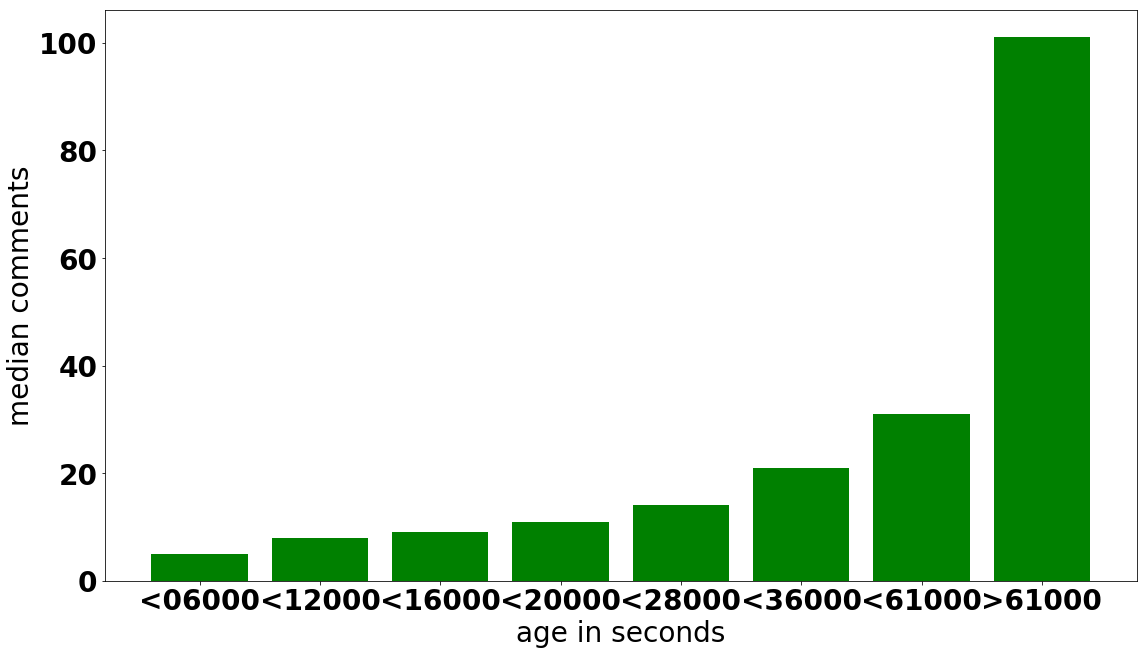

In [409]:
bars = matplotlib.pyplot.bar(age_comms_df['ages'], age_comms_df['comms'], color = 'green')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)


font = {'weight' : 'bold',
        'size'   : 28}

matplotlib.rc('font', **font)
matplotlib.pyplot.xlabel('age in seconds')
matplotlib.pyplot.ylabel('median comments')

In [377]:
crossposts = pd.DataFrame(allreds['num_crossposts'])

crossposts['new_index'] = range(crossposts.shape[0])

crossposts.set_index('new_index', inplace = True)

In [378]:
posts_comms = pd.concat([comms, crossposts], axis = 1)

In [379]:
posts_comms.describe()

,num_comments,num_crossposts
count,7775.000000,7775.000000
mean,60.103408,0.174148
std,401.640102,0.763036
min,0.000000,0.000000
25%,5.000000,0.000000
50%,14.000000,0.000000
75%,38.000000,0.000000
max,29719.000000,15.000000


In [381]:
(posts_comms['num_crossposts'] > 1).sum()

247

In [396]:
cross_df = pd.DataFrame(['0', '1', '2', '3', '7', '12'])

In [397]:
comms_1 = posts_comms.loc[posts_comms['num_crossposts'] == 0, :]['num_comments'].median()
comms_1

13.0

In [398]:
comms_2 = posts_comms.loc[posts_comms['num_crossposts'] == 1, :]['num_comments'].median()
comms_2

38.5

In [399]:
comms_3 = posts_comms.loc[posts_comms['num_crossposts'] == 2, :]['num_comments'].median()
comms_3

94.0

In [400]:
comms_4 = posts_comms.loc[posts_comms['num_crossposts'] == 3, :]['num_comments'].median()
comms_4

345.0

In [401]:
comms_5 = posts_comms.loc[(posts_comms['num_crossposts'] <= 7) & (posts_comms['num_crossposts'] > 3)
                          , :]['num_comments'].median()
comms_5

392.5

In [402]:
comms_6 = posts_comms.loc[(posts_comms['num_crossposts'] <= 12) & (posts_comms['num_crossposts'] > 7)
                                                                   , :]['num_comments'].median()
comms_6

553.0

In [403]:
comms_7 = posts_comms.loc[posts_comms['num_crossposts'] > 12, :]['num_comments'].median()
comms_7

852.5

In [415]:
cross_df = pd.DataFrame(['0', '1', '2', '3', '4-7', '8-12', '>12'], columns = ['cross'])

comms2_df = pd.DataFrame([comms_1, comms_2, comms_3, comms_4,
                       comms_5, comms_6, comms_7], columns = ['comms'])

cross_comms_df = pd.concat([comms2_df, cross_df], axis = 1)

Text(0,0.5,'median comments')

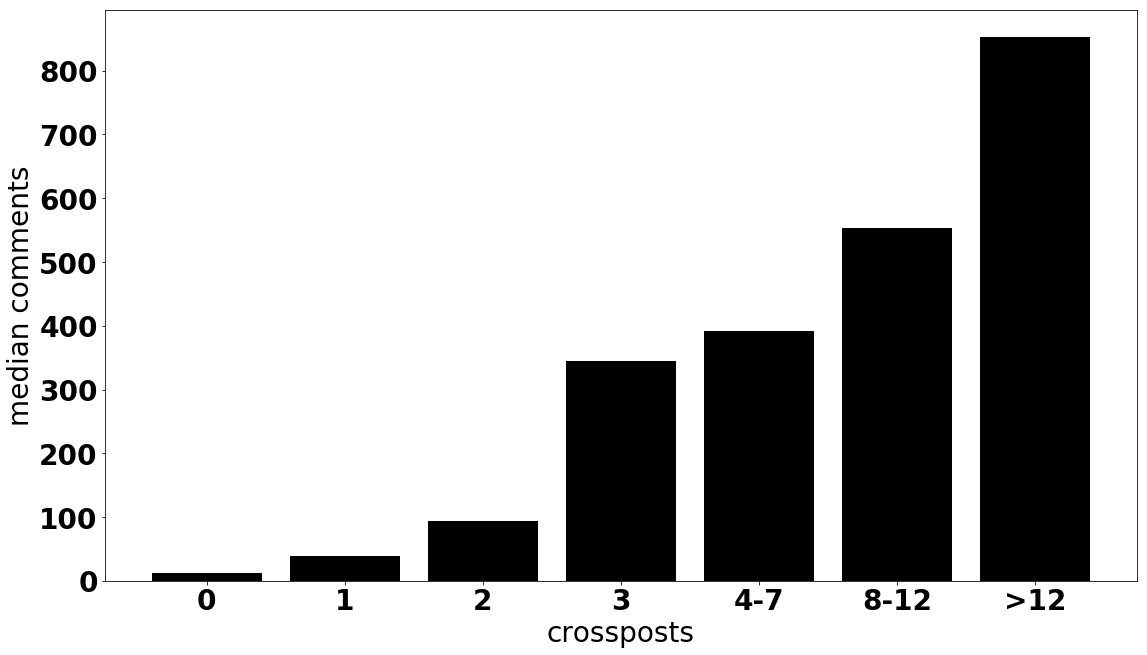

In [416]:
bars = matplotlib.pyplot.bar(cross_comms_df['cross'], cross_comms_df['comms'], color = 'k')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)


font = {'weight' : 'bold',
        'size'   : 28}

matplotlib.rc('font', **font)
matplotlib.pyplot.xlabel('crossposts')
matplotlib.pyplot.ylabel('median comments')

### GRIDSEARCHING (AND PIPELINING PRACTICE)

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [56]:
gaussbay = naive_bayes.GaussianNB()

In [57]:
pipe = Pipeline([
    ('nb', gaussbay)
])

In [67]:
gauss_params = {
    'nb__priors': [[0.04, 0.96], [0.02, 0.98], [0.03, 0.97]]
}
gs = GridSearchCV(pipe, param_grid = gauss_params)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.6938775510204082
{'nb__priors': [0.02, 0.98]}


In [60]:
multbay = naive_bayes.MultinomialNB()

In [62]:
pipe_mult = Pipeline([
    ('nb', multbay)
])

In [68]:
mult_params = {
    'nb__alpha': [0.8, 0.6],
    'nb__fit_prior': [True, False],
    'nb__class_prior': [[0.02, 0.98], [0.03, 0.97]]
}
gs = GridSearchCV(pipe_mult, param_grid = mult_params)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.5234093637454982
{'nb__alpha': 0.8, 'nb__class_prior': [0.02, 0.98], 'nb__fit_prior': True}


## Predicting comments using Random Forests + Another Classifier

Let's try a single decision tree first.

In [69]:
from sklearn.tree import DecisionTreeClassifier

In [84]:
tree = DecisionTreeClassifier(max_depth = 6, min_samples_split = 2, min_samples_leaf = 1)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [85]:
tree.score(X_test, y_test)

0.727366255144033

In [86]:
cross_val_score(tree, X_test, y_test)

array([0.73765432, 0.69135802, 0.70987654])

Let's try pipelining and gridsearching this, too.

In [77]:
pipe_tree = Pipeline([
    ('tree', tree)
])

In [81]:
tree_params = {
    'tree__max_depth': [7, 6],
    'tree__min_samples_split': [2],
    'tree__min_samples_leaf': [1],
    'tree__splitter': ['best', 'random']
}
gs = GridSearchCV(pipe_tree, param_grid = tree_params)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.7106842737094838
{'tree__max_depth': 7, 'tree__min_samples_leaf': 1, 'tree__min_samples_split': 2, 'tree__splitter': 'best'}


#### Load in the the data of scraped results

I reconstructed ```allreds``` in the same way by concatenating the .csv's from the six scrapes.

#### We want to predict a binary variable - whether the number of comments was low or high. Compute the median number of comments and create a new binary variable that is true when the number of comments is high (above the median)

We could also perform Linear Regression (or any regression) to predict the number of comments here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW number of comments.

While performing regression may be better, performing classification may help remove some of the noise of the extremely popular threads. We don't _have_ to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of comment numbers. 

In [14]:
allreds['num_comments'].median()

14.0

#### Thought experiment: What is the baseline accuracy for this model?

Since by definition the median separates the top 50% from the bottom 50%, the baseline accuracy for this will be as low as it can be for a two-class model, i.e. 50%.

#### Create a Random Forest model to predict High/Low number of comments using Sklearn. Start by ONLY using the subreddit as a feature. 

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [12]:
allreds['success?'] = allreds['num_comments'] >= allreds['num_comments'].median()

In [13]:
X_for = pd.get_dummies(allreds['subreddit'])
y_for = allreds['success?']

In [45]:
from sklearn.model_selection import train_test_split

In [15]:
X_train_for, X_test_for, y_train_for, y_test_for = train_test_split(X_for, y_for)

In [16]:
rf = RandomForestClassifier()
rf.fit(X_train_for, y_train_for)
rf.score(X_test_for, y_test_for)

0.63940329218107

#### Create a few new variables in your dataframe to represent interesting features of a thread title.
- For example, create a feature that represents whether 'cat' is in the title or whether 'funny' is in the title. 
- Then build a new Random Forest with these features. Do they add any value?
- After creating these variables, use count-vectorizer to create features based on the words in the thread titles.
- Build a new random forest model with subreddit and these new features included.

In [17]:
post_list = ['post' in title for title in allreds['title']]

In [18]:
allreds['post?'] = post_list

In [19]:
just_list = ['just' in title for title in allreds['title']]

In [20]:
allreds['just?'] = just_list

In [21]:
hilarious_list = ['hilarious' in title for title in allreds['title']]

In [22]:
allreds['hilarious?'] = hilarious_list

In [23]:
X_for = pd.concat([pd.get_dummies(allreds['subreddit']), allreds['post?'], allreds['just?'], allreds['hilarious?']],
                   axis = 1)
y_for = allreds['success?']

In [25]:
X_train_for, X_test_for, y_train_for, y_test_for = train_test_split(X_for, y_for)

rf = RandomForestClassifier()
rf.fit(X_train_for, y_train_for)
rf.score(X_test_for, y_test_for)

0.6409465020576132

They do seem to add a small bit of value.

##### Vectorizer

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

In [27]:
cvec = CountVectorizer(stop_words = 'english', ngram_range = (1, 2))

In [28]:
cvec.fit(allreds['title'].tolist())

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [29]:
vec_titles = cvec.transform(allreds['title'].tolist())

In [30]:
df_vec = pd.DataFrame(vec_titles.todense(),
                   columns=cvec.get_feature_names())

In [34]:
sub_dums = pd.get_dummies(allreds['subreddit'])

In [35]:
sub_dums['new_index'] = range(sub_dums.shape[0])

In [37]:
sub_dums = sub_dums.set_index('new_index')

In [39]:
X_for = pd.concat([sub_dums, df_vec], axis = 1)
y_for = allreds['success?']

In [46]:
X_train_for, X_test_for, y_train_for, y_test_for = train_test_split(X_for, y_for)

rf = RandomForestClassifier()
rf.fit(X_train_for, y_train_for)
rf.score(X_test_for, y_test_for)

0.5838477366255144

#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy of the model, as well as any other metrics you feel are appropriate. 

As long as we're cross-validating, we may as well grid-search as well!

In [52]:
from sklearn.model_selection import cross_val_score, GridSearchCV

In [53]:
cross_val_score(rf, X_for, y_for)

array([0.54839954, 0.53956002, 0.60324199])

In [59]:
cross_val_score(rf, X_for, y_for, scoring = 'precision')

array([0.68055556, 0.60323887, 0.68315665])

In [60]:
cross_val_score(rf, X_for, y_for, scoring = 'recall')

array([0.24813154, 0.34854151, 0.4592371 ])

In [51]:
forest_params = {
    'n_estimators': [10, 20],
    'criterion': ['gini', 'entropy']
}
gs = GridSearchCV(rf, param_grid = forest_params)

gs.fit(X_for, y_for)
print(gs.best_score_)
print(gs.best_params_)

0.5696463022508038
{'n_estimators': 20}


In [56]:
forest_params = {
    'n_estimators': [30, 20],
    'criterion': ['gini', 'entropy'],
}
gs = GridSearchCV(rf, param_grid = forest_params, scoring = 'precision')

gs.fit(X_for, y_for)
print(gs.best_score_)
print(gs.best_params_)

0.6611930578925773
{'criterion': 'entropy', 'n_estimators': 20}


In [57]:
forest_params = {
    'max_depth': [2, 3, 4],
    'n_estimators': [20],
    'criterion': ['gini', 'entropy']
}
gs = GridSearchCV(rf, param_grid = forest_params, scoring = 'recall')
        # Remember: 'Recall' and 'sensitivity' are synonyms!

gs.fit(X_for, y_for)
print(gs.best_score_)
print(gs.best_params_)

0.9927716710498267
{'criterion': 'entropy', 'max_depth': 2, 'n_estimators': 20}


In [58]:
gs.score(X_test_for, y_test_for)

0.998998998998999

This excellent sensitivity score means that there are very few false negatives, i.e. cases of successful posts incorrectly predicted to be unsuccessful.

#### Repeat the model-building process with a non-tree-based method.

In [ ]:
# See above.

#### Use Count Vectorizer from scikit-learn to create features from the thread titles. 
- Examine using count or binary features in the model
- Re-evaluate your models using these. Does this improve the model performance? 
- What text features are the most valuable? 

In [ ]:
# See above.

# Executive Summary
---
Put your executive summary in a Markdown cell below.

According to Alexa, reddit.com is now the third-most popular site in the U.S., outpacing Facebook, Wikipedia, Amazon, and indeed every site except Google and YouTube (https://www.alexa.com/topsites/countries/US). Fivethirtyeight therefore should have a genuine interest in data to do with Reddit. Moreover, Reddit attracts a very broad segment of the population, with users commenting heavily on issues of interest to fivethirtyeight: politics, sports, science & health, economics, and culture.

Reddit is one of the world's biggest platforms for garnering social media attention, and thus there is an obvious question for all aspiring media giants, which is how one can stack the deck and increase the odds of having a successful Reddit post.

I have the tools to answer this question. I will analyze the data and uncover the secrets of successful Redditing. I have gathered 7775 Reddit threads and am now exploring various of their features (identity of subreddit(s), how long the post has been up, whether the parent has been whitelisted, etc.), examining especially how these features correlate with success, which I have defined as having an above-median number of comments.

I will try tree-based as well as naive Bayesian models, optimizing them by tuning over hyperparameters.

The results will be a precious commodity, and I am offering fivethirtyeight first crack at publishing them. I shall detail my procedures in another document, but suffice it to say that you can't afford to miss out on this opportunity to be the source of the secrets on how to have a successful Reddit thread!

### BONUS
Refer to the README for the bonus parts